In [15]:
import glob
import os
import re
import datetime
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
pd.options.display.max_columns = 50

In [17]:
# NCAA women's RPI: https://www.ncaa.com/rankings/basketball-women/d1/ncaa-womens-basketball-rpi

In [18]:
# data_files = glob.glob(os.path.expanduser('~/Dropbox/Uncertain Principles/Articles/NCAAWomen2019/data/*csv'))

# print('Number of game files: {}'.format(len(data_files)))

# game_data = None
# file_dates = list()
# for data_file in data_files:
#     m = re.search('.*(\d\d-\d\d-\d\d\d\d).csv', data_file)
#     if m is not None:
#         file_date = datetime.datetime.strptime(m.groups()[0], '%m-%d-%Y').date()
#         file_dates.append(file_date)
    
#     df = pd.read_csv(data_file)
    
#     if game_data is None:
#         game_data = df
#     else:
#         game_data = game_data.append(df)

# # There are a few duplicate rows. Drop duplicates to be safe.
# game_data = game_data.drop_duplicates()

# game_data.reset_index(drop=True, inplace=True)
    
# print('Number of individual games: {}'.format(game_data.shape[0]))
# print('Most recent file date: {}'.format(max(file_dates)))

In [19]:
input_path = 'final_team_data.csv'
game_data = pd.read_csv(input_path)
n_games, n_featureds = game_data.shape
print('Number of individual games: {}'.format(n_games))
game_data.head()

Number of individual games: 5191


,game_id,gamedate,guest,guest_score,home,home_score,neutral_location,spread,guest_id,home_id,home_3FG,home_3FGA,home_FGM,home_FGA,home_FT,home_FTA,guest_3FG,guest_3FGA,guest_FGM,guest_FGA,guest_FT,guest_FTA,home_consistent,guest_consistent
0,1004/2/03/02/2019,03/02/2019,Abilene Christian,67,Central Ark.,65,False,-2,2,1004,5,17,21,60,18,22,4,16,21,46,21,30,True,True
1,1004/2/03/15/2019,03/15/2019,Abilene Christian,82,Central Ark.,54,True,-28,2,1004,3,14,19,56,13,20,16,35,29,59,8,10,True,True
2,1004/26172/12/31/2018,12/31/2018,A&M-Corpus Christi,73,Central Ark.,65,False,-8,26172,1004,7,18,22,57,14,17,4,13,25,61,19,28,True,True
3,1004/2743/01/16/2019,01/16/2019,Incarnate Word,43,Central Ark.,74,False,31,2743,1004,8,19,28,60,10,16,3,15,15,43,10,15,True,True
4,1004/402/02/20/2019,02/20/2019,McNeese,45,Central Ark.,76,False,31,402,1004,6,11,24,50,22,28,2,12,17,55,9,20,True,True


In [20]:
left = game_data[['guest', 'gamedate']].groupby('guest').count().reset_index()
right = game_data[['home', 'gamedate']].groupby('home').count().reset_index()

df2 = left.merge(right, left_on='guest', right_on='home')
df2['n_games'] = df2['gamedate_x'] + df2['gamedate_y']

n_d1_teams = df2[['home', 'n_games']][df2['n_games'] > 20].shape[0]

print('Number of D1 teams in data: {}'.format(n_d1_teams))

teams = df2[['home']][df2['n_games'] > 20].rename(index=str, columns={'home': 'name'})
teams.reset_index(inplace=True, drop=True)
teams.reset_index(inplace=True)

# Example: get the index of a team by name
# int(teams.index[teams['name'] == 'Air Force'].tolist()[0])

teams.head()

Number of D1 teams in data: 349


,index,name
0,0,A&M-Corpus Christi
1,1,Abilene Christian
2,2,Air Force
3,3,Akron
4,4,Alabama


In [29]:
# game_data['spread'] = game_data['home_score'] - game_data['guest_score']

game_data = game_data.merge(teams, left_on='guest', right_on='name') \
                     .rename(index=str, columns={'index': 'guest_index'}) \
                     .drop('name', axis=1)
game_data = game_data.merge(teams, left_on='home', right_on='name') \
                     .rename(index=str, columns={'index': 'home_index'}) \
                     .drop('name', axis=1)

game_data.head()

,game_id,gamedate,guest,guest_score,home,home_score,neutral_location,spread,guest_id,home_id,home_3FG,home_3FGA,home_FGM,home_FGA,home_FT,home_FTA,guest_3FG,guest_3FGA,guest_FGM,guest_FGA,guest_FT,guest_FTA,home_consistent,guest_consistent,guest_index,home_index
0,1004/2/03/02/2019,03/02/2019,Abilene Christian,67,Central Ark.,65,False,-2,2,1004,5,17,21,60,18,22,4,16,21,46,21,30,True,True,1,42
1,1004/2/03/15/2019,03/15/2019,Abilene Christian,82,Central Ark.,54,True,-28,2,1004,3,14,19,56,13,20,16,35,29,59,8,10,True,True,1,42
2,1004/26172/12/31/2018,12/31/2018,A&M-Corpus Christi,73,Central Ark.,65,False,-8,26172,1004,7,18,22,57,14,17,4,13,25,61,19,28,True,True,0,42
3,1004/2743/01/16/2019,01/16/2019,Incarnate Word,43,Central Ark.,74,False,31,2743,1004,8,19,28,60,10,16,3,15,15,43,10,15,True,True,119,42
4,1004/402/02/20/2019,02/20/2019,McNeese,45,Central Ark.,76,False,31,402,1004,6,11,24,50,22,28,2,12,17,55,9,20,True,True,159,42


In [164]:
# teams['FGA'] = np.random.randint(50,100,teams.shape[0])
# teams['FG'] = np.floor(teams['FGA']*0.5).astype('int')
# teams['3FGA'] = np.floor(teams['FGA']*0.4).astype('int')
# teams['3FG'] = np.floor(teams['FG']*0.3).astype('int')
# teams['FTA'] = np.random.randint(20,30,teams.shape[0])
# teams['FT'] = np.floor(teams['FTA']*0.8).astype('int')

# teams['2FGA'] = teams['FGA'] - teams['3FGA']
# teams['2FG'] = teams['FG'] - teams['3FG']

In [165]:
a = teams[teams['name'].str.contains('Stanford')]
a

,index,name,FGA,FG,3FGA,3FG,FTA,FT,2FGA,2FG
278,278,Stanford,81,40,32,12,23,18,49,28


In [206]:
miss = np.array([2]*int(a['2FGA'] - a['2FG']) + [3]*int(a['3FGA'] - a['3FG']) + [1]*int(a['FTA'] - a['FT']))

make = np.array([2]*int(a['2FG']) + [3]*int(a['3FG']) + [1]*int(a['FT']))

reverse_miss = np.array([np.random.choice((0, 1), p=(0.9, 0.1))*si for i, si in enumerate(miss)])
reverse_make = np.array([np.random.choice((0, 1), p=(0.8, 0.2))*si for i, si in enumerate(make)])

new_score = sum(make) + sum(reverse_miss) - sum(reverse_make)

print(sum(make), new_score)

(110, 114)


In [39]:
for team in ['home', 'guest']:
    game_data['{}_2FGA'.format(team)] = game_data['{}_FGA'.format(team)] - game_data['{}_3FGA'.format(team)]
    game_data['{}_2FG'.format(team)] = game_data['{}_FGM'.format(team)]  - game_data['{}_3FG'.format(team)]

In [48]:
#(game_data['{}_2FGA'.format(team)] - game_data['{}_2FG'.format(team)])

In [57]:
for row in game_data.iterrows():
     break

In [141]:
game = row[1]

luck2(game, 0.1, 0.2)

('home', 65, 67)
('guest', 67, 53)
-2 14 16


In [143]:
def luck2(game, reverse_miss_p, reverse_make_p):

    for team in ['home', 'guest']:
        miss = np.array([2]*int(game['{}_2FGA'.format(team)] - game['{}_2FG'.format(team)]) + \
                        [3]*int(game['{}_3FGA'.format(team)] - game['{}_3FG'.format(team)]) + \
                        [1]*int(game['{}_FTA'.format(team)]  - game['{}_FT'.format(team)]))

        make = np.array([2]*int(game['{}_2FG'.format(team)]) + \
                        [3]*int(game['{}_3FG'.format(team)]) + \
                        [1]*int(game['{}_FT'.format(team)]))

        reverse_miss = np.array([np.random.choice((0, 1), p=(1.0-reverse_miss_p, reverse_miss_p))*si for i, si in enumerate(miss)])
        reverse_make = np.array([np.random.choice((0, 1), p=(1.0-reverse_make_p, reverse_make_p))*si for i, si in enumerate(make)])

        new_score = sum(make) + sum(reverse_miss) - sum(reverse_make)
        if team == 'home':
            new_home_score = new_score
        else:
            new_guest_score = new_score
            
    new_spread = new_home_score - new_guest_score
    
    delta_spread = new_spread - game['spread']
    
    return delta_spread

In [208]:
rank[rank['name'].str.contains('Miss')]

,LRMC,team_index,LRMC_rank,index,name,ngames
170,0.008499,170,4.0,170,Mississippi St.,32
171,0.001383,171,332.0,171,Mississippi Val.,30
172,0.005130,172,21.0,172,Missouri,33
173,0.004017,173,57.0,173,Missouri St.,32
215,0.002784,215,145.0,215,Ole Miss,31
272,0.002261,272,205.0,272,Southern Miss.,28


In [209]:
rank[rank['name'].str.contains('Ok')]

,LRMC,team_index,LRMC_rank,index,name,ngames
212,0.003267,212,104.0,212,Oklahoma,30
213,0.003590,213,77.0,213,Oklahoma St.,30


In [30]:
# set some constants
tau = 4.26
sig = 11 
h   = 4

# code to compute the probability that one team is better than another based on point spread, x.
# compute P(Z>0 | X=x) from eq. (12) pnorm(2*tau^2/(sig*sqrt((sig^2+2*tau^2)*(sig^2+4*tau^2)))*x - h/sig*sqrt((sig^2+4*tau^2)/(sig^2+2*tau^2))) 
a = 2*(tau**2)/(sig*np.sqrt(((sig**2)+2*(tau**2))*((sig**2)+4*(tau**2))))
b = 2*(tau**2)*h/(sig*np.sqrt(((sig**2)+2*(tau**2))*((sig**2)+4*(tau**2))))

In [31]:
def luck(shots, pm, points):
    # shots (1, 3) --> range(randint(1, 3+1))
    # pm (3, 2) --> [-1]*3 + [1]*2
    # points (1, 5, 2) --> [1]*1 + [2]*5 + [3]*2
    
    shots_list = range(np.random.randint(shots[0], shots[1] + 1))
    pm_list = [-1]*pm[0]  + [1]*pm[1]
    points_list = [1]*points[0] + [2]*points[1] + [3]*points[2]
    
    luck_points = sum([ np.random.choice(pm_list)*np.random.choice(points_list) for i in shots_list ])

    return luck_points

In [ ]:
fta - 500-600 per season
fga - 1900-2000
3ga - 700-800

so 1:3:2
        
550, 1200, 750 

roughly... 15:33:20
        
pm = 1:1 even though miss is more likely since we're talking abotu spread - so it's as likely to be home as away that misses

(array([    0.,     0.,     0.,     0.,    83.,   266.,   259.,   667.,
          976.,   754.,  3960.,   784.,   985.,   654.,   318.,   226.,
           68.,     0.,     0.]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 <a list of 19 Patch objects>)

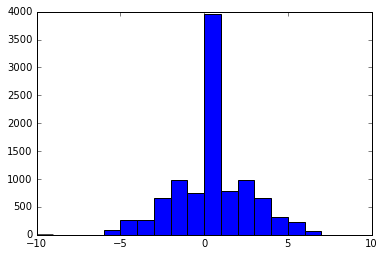

In [24]:
ldata = [luck((0, 2), (1, 1), (15, 33, 20)) for i in range(10000)]
plt.hist(ldata, bins=range(-10, 10))

(array([   10.,    48.,    63.,   114.,   199.,   310.,   422.,   734.,
          976.,   792.,  2679.,   791.,   967.,   778.,   436.,   289.,
          157.,   102.,   102.]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 <a list of 19 Patch objects>)

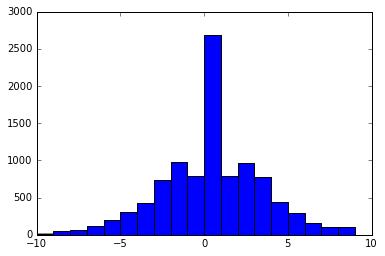

In [25]:
ldata = [luck((0, 4), (1, 1), (15, 33, 20)) for i in range(10000)]
plt.hist(ldata, bins=range(-10, 10))

(array([    8.,    12.,    28.,    34.,    67.,    69.,   102.,   170.,
          221.,   276.,   401.,   472.,   663.,   807.,   728.,  1823.,
          776.,   838.,   697.,   445.,   398.,   289.,   198.,   155.,
          103.,    74.,    64.,    23.,    36.]),
 array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
         -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14]),
 <a list of 29 Patch objects>)

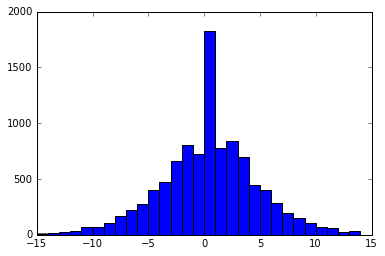

In [26]:
ldata = [luck((0, 8), (1, 1), (15, 33, 20)) for i in range(10000)]
plt.hist(ldata, bins=range(-15, 15))

(array([ 0.,  0.,  2.,  6.,  6.,  2.,  0.,  0.,  0.]),
 array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110]),
 <a list of 9 Patch objects>)

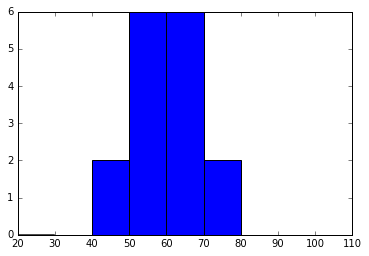

In [27]:
plt.hist(game_data[game_data['home'].str.contains('A&M-Corpus')]['home_score'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100, 110])

In [28]:
game_data.groupby('home')['home_score'].agg(['mean', 'std'])

,mean,std
home,,
A&M-Corpus Christi,61.437500,9.294936
Abilene Christian,78.083333,16.317633
Air Force,64.928571,14.144661
Akron,66.705882,9.853709
Alabama,66.875000,13.285957
Alabama A&M,59.076923,12.932269
Alabama St.,62.500000,14.241425
Albany (NY),57.357143,6.356186
Alcorn,58.250000,7.098335


In [32]:
start = datetime.datetime.now()

t = np.zeros((n_d1_teams, n_d1_teams))
teams['ngames'] = 0

for k, row in game_data.iterrows():
    try:
        i = int(row['home_index'])
        j = int(row['guest_index'])
        
        spread = row['spread']

        if not np.isnan(spread):
            # Sometimes a gametime is posted before the score is known in the data
            # This leads to an undefined spread
            # Skip for now and hope the score is captured in a later update
            
            teams.loc[teams['index'] == i, 'ngames'] += 1
            teams.loc[teams['index'] == j, 'ngames'] += 1

            r = scipy.stats.norm.cdf(a*spread-b)    
            t[i,j] = t[i,j] + (1.0 - r)
            t[j,i] = t[j,i] + r
            t[i,i] = t[i,i] + r
            t[j,j] = t[j,j] + (1.0 - r)
    except:
        print(i, j, spread, row['home'], row['guest'], row['gametime'], r)
        raise

end = datetime.datetime.now()
print((end - start).total_seconds())

25.729341


In [33]:
for i in range(n_d1_teams):
    t[i] = t[i] / float(teams[teams['index'] == i]['ngames'])

In [34]:
#initialize ranking procedure
p = np.zeros((1, n_d1_teams))

z = float(np.sum(range(1, n_d1_teams+1)))
for i in range(n_d1_teams):
    p[0, i] = (n_d1_teams - i)/z

In [35]:
# run ranking procedure
for itr in range(1000):
    p_next = np.matmul(p, t)
    if(itr % 100 == 0):
        print(np.linalg.norm(p_next - p))
    p = p_next

0.0178848881366
7.82416828436e-07
1.94883099087e-09
4.84081188865e-12
1.20219278085e-14
3.09010933635e-17
0.0
0.0
0.0
0.0


In [36]:
teams[teams['index'] == np.argmax(p)]

,index,name,ngames
206,206,Notre Dame,33


In [37]:
rank = pd.DataFrame({'LRMC': p[0], 'team_index': range(n_d1_teams)})
rank['LRMC_rank'] = rank['LRMC'].rank(ascending=False)
rank = rank.merge(teams, left_on='team_index', right_on='index', how='left')
rank[(0 < rank['LRMC_rank']) & (rank['LRMC_rank'] <= 80)].sort_values('LRMC_rank')

,LRMC,team_index,LRMC_rank,index,name,ngames
206,0.009654,206,1.0,206,Notre Dame,33
302,0.009382,302,2.0,302,UConn,33
21,0.009056,21,3.0,21,Baylor,32
169,0.008669,169,4.0,169,Mississippi St.,32
216,0.008090,216,5.0,216,Oregon,32
155,0.007462,155,6.0,155,Marquette,33
148,0.007117,148,7.0,148,Louisville,32
276,0.006900,276,8.0,276,Stanford,32
124,0.006588,124,9.0,124,Iowa St.,33
123,0.005949,123,10.0,123,Iowa,32


In [ ]:
# Note that the top three teams each have over 1000 games played: BUG!

In [16]:
output_path = 'standard_LRMC.csv'
# rank.sort_values('LRMC_rank').to_csv(output_path, index=False)

standard_rank = pd.read_csv(output_path)
standard_rank[(0 < standard_rank['LRMC_rank']) & (standard_rank['LRMC_rank'] <= 4)]

,LRMC,team_index,LRMC_rank,index,name,ngames
0,0.009586,208,1.0,208,Notre Dame,33
1,0.009185,304,2.0,304,UConn,33
2,0.009044,21,3.0,21,Baylor,32
3,0.008499,170,4.0,170,Mississippi St.,32


In [17]:
import itertools

In [26]:
#game_data.groupby('home').count().reset_index()
game_data['home_score'].mean(), game_data['guest_score'].mean()

(67.100896433339685, 62.816326530612244)

In [30]:
game_data['home_score'].std(), game_data['guest_score'].std()

(13.60690867587542, 13.015297271936403)

In [62]:
def rel_rank(team_1, team_2):
    t1 = rank[rank['name'].str.contains(team_1)][['name', 'LRMC', 'LRMC_rank']]
    t2 = rank[rank['name'].str.contains(team_2)][['name', 'LRMC', 'LRMC_rank']]

    if list(t1['LRMC_rank'])[0] < list(t2['LRMC_rank'])[0]:
        t1['winner'] = 'O'
        t2['winner'] = ''
    else:
        t1['winner'] = ''
        t2['winner'] = 'O'
    
    vs = t1.append(t2)
    
    return vs
    
rel_rank('Maryland', 'Stanf')

,name,LRMC,LRMC_rank,winner
151,Loyola Maryland,0.001859,273.0,
158,Maryland,0.005585,12.0,
278,Stanford,0.006712,8.0,O


In [21]:
'_'.join(map(str, list(itertools.chain.from_iterable(((1,2), (3,4), (5,6,7))))))

'1_2_3_4_5_6_7'

In [154]:
n_trials = 100
t = np.zeros((n_d1_teams, n_d1_teams, n_trials))

for trial in range(n_trials):
    start = datetime.datetime.now()
    teams['ngames'] = 0

    for k, row in game_data.iterrows():
        try:
            i = int(row['home_index'])
            j = int(row['guest_index'])

            spread0 = row['spread']

            if not np.isnan(spread0):

                spread = spread0 + luck((0, 3), (3, 2), (1, 5, 2))

                # Sometimes a gametime is posted before the score is known in the data
                # This leads to an undefined spread
                # Skip for now and hope the score is captured in a later update

                teams.loc[teams['index'] == i, 'ngames'] += 1
                teams.loc[teams['index'] == j, 'ngames'] += 1

                r = scipy.stats.norm.cdf(a*spread-b)    
                t[i,j,trial] = t[i,j,trial] + (1.0 - r)
                t[j,i,trial] = t[j,i,trial] + r
                t[i,i,trial] = t[i,i,trial] + r
                t[j,j,trial] = t[j,j,trial] + (1.0 - r)
        except:
            print(i, j, spread, row['home'], row['guest'], row['gametime'], r)
            raise

    for i in range(n_d1_teams):
       t[i,:,trial] = t[i,:,trial] / float(teams[teams['index'] == i]['ngames'])
 
    #initialize ranking procedure
    p = np.zeros((1, n_d1_teams))

    z = float(np.sum(range(1, n_d1_teams+1)))
    for i in range(n_d1_teams):
        p[0, i] = (n_d1_teams - i)/z

    # run ranking procedure
    for itr in range(1000):
        p_next = np.matmul(p, t[:,:,trial])
        #if(itr % 100 == 0):
        #    print(np.linalg.norm(p_next - p))
        p = p_next

    rank = pd.DataFrame({'LRMC': p[0], 'team_index': range(n_d1_teams)})
    rank['LRMC_rank'] = rank['LRMC'].rank(ascending=False)
    rank = rank.merge(teams, left_on='team_index', right_on='index', how='left')
    
    output_path = 'LRMC_rank.{}.csv'.format(trial)
    rank.sort_values('LRMC_rank').to_csv(output_path, index=False)

    print('trial {} of {}'.format(trial, n_trials))
    print('output ranking to: {}'.format(output_path))
    print(rank[(0 < rank['LRMC_rank']) & (rank['LRMC_rank'] <= 4)].sort_values('LRMC_rank'))

    end = datetime.datetime.now()
    print('Trial time in seconds: {}'.format((end - start).total_seconds()))

trial 0 of 100
output ranking to: LRMC_rank.0.csv
         LRMC  team_index  LRMC_rank  index             name  ngames
208  0.009657         208        1.0    208       Notre Dame      33
304  0.009537         304        2.0    304            UConn      33
21   0.009022          21        3.0     21           Baylor      32
170  0.008346         170        4.0    170  Mississippi St.      32
Trial time in seconds: 32.613554
trial 1 of 100
output ranking to: LRMC_rank.1.csv
         LRMC  team_index  LRMC_rank  index             name  ngames
208  0.009460         208        1.0    208       Notre Dame      33
304  0.009231         304        2.0    304            UConn      33
21   0.009042          21        3.0     21           Baylor      32
170  0.008414         170        4.0    170  Mississippi St.      32
Trial time in seconds: 31.909958
trial 2 of 100
output ranking to: LRMC_rank.2.csv
         LRMC  team_index  LRMC_rank  index             name  ngames
208  0.009573         208

In [160]:
standard_rank[standard_rank['name'].str.contains('Tenn')]

,LRMC,team_index,LRMC_rank,index,name,ngames
37,0.004471,284,38.0,284,Tennessee,31
87,0.003464,167,88.0,167,Middle Tenn.,31
179,0.002479,286,180.0,286,Tennessee Tech,29
297,0.001699,285,298.0,285,Tennessee St.,30


In [151]:
#initialize ranking procedure
p = np.zeros((1, n_d1_teams))

z = float(np.sum(range(1, n_d1_teams+1)))
for i in range(n_d1_teams):
    p[0, i] = (n_d1_teams - i)/z
    
# run ranking procedure
for itr in range(1000):
    p_next = np.matmul(p, t[:,:,1])
    if(itr % 100 == 0):
        print(np.linalg.norm(p_next - p))
    p = p_next
    
rank = pd.DataFrame({'LRMC': p[0], 'team_index': range(n_d1_teams)})
rank['LRMC_rank'] = rank['LRMC'].rank(ascending=False)
rank = rank.merge(teams, left_on='team_index', right_on='index', how='left')
rank[(20 < rank['LRMC_rank']) & (rank['LRMC_rank'] <= 25)].sort_values('LRMC_rank')

0.017731169787
7.29622071955e-07
1.86939700026e-09
4.7776385149e-12
1.22085133113e-14
3.30060773884e-17
0.0
0.0
0.0
0.0


,LRMC,team_index,LRMC_rank,index,name,ngames
287,0.005109,287,21.0,287,Texas,32
65,0.005086,65,22.0,65,DePaul,33
172,0.005074,172,23.0,172,Missouri,33
134,0.005016,134,24.0,134,Kentucky,31
183,0.004863,183,25.0,183,NC State,31
